In [72]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
from datetime import datetime

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import r2_score as r2
from sklearn.model_selection import KFold, GridSearchCV

%matplotlib inline
import warnings
warnings.filterwarnings('ignore')
matplotlib.rcParams.update({'font.size': 14})
%config InlineBackend.figure_format = 'svg'

In [73]:
test = pd.read_csv('test.csv')
train = pd.read_csv('train.csv')

In [74]:
train.head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
0,11809,27,3.0,115.027311,NaN,10.0,4,10.0,2014,0.075424,B,B,11,3097,0,NaN,0,0,B,305018.871089
1,3013,22,1.0,39.832524,23.169223,8.0,7,8.0,1966,0.118537,B,B,30,6207,1,1183.0,1,0,B,177734.553407
2,8215,1,3.0,78.342215,47.671972,10.0,2,17.0,1988,0.025609,B,B,33,5261,0,240.0,3,1,B,282078.720850
3,2352,1,1.0,40.409907,NaN,1.0,10,22.0,1977,0.007122,B,B,1,264,0,NaN,0,1,B,168106.007630
4,13866,94,2.0,64.285067,38.562517,9.0,16,16.0,1972,0.282798,B,B,33,8667,2,NaN,0,6,B,343995.102962


In [75]:
test.head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2
0,4567,44,1.0,36.847630,19.094182,5.0,5,9.0,1970,0.036122,B,B,24,4378,0,1036.0,1,1,B
1,5925,62,1.0,42.493907,42.568133,10.0,7,17.0,2017,0.072158,B,B,2,629,1,NaN,0,0,A
2,960,27,2.0,59.463678,NaN,9.0,19,19.0,1977,0.211401,B,B,9,1892,0,NaN,0,1,B
3,3848,23,3.0,49.646030,33.893825,6.0,2,2.0,1965,0.014073,B,B,2,475,0,NaN,0,0,B
4,746,74,1.0,53.837056,NaN,1.0,8,17.0,1977,0.309479,B,B,35,7715,4,990.0,0,6,B


In [76]:
train.dtypes

Id                 int64
DistrictId         int64
Rooms            float64
Square           float64
LifeSquare       float64
KitchenSquare    float64
Floor              int64
HouseFloor       float64
HouseYear          int64
Ecology_1        float64
Ecology_2         object
Ecology_3         object
Social_1           int64
Social_2           int64
Social_3           int64
Healthcare_1     float64
Helthcare_2        int64
Shops_1            int64
Shops_2           object
Price            float64
dtype: object

Привожу айди и айди района к строковому типу данных

In [77]:
train.Id = train.Id.astype(str)
train.DistrictId = train.DistrictId.astype(str)
train.HouseFloor = train.HouseFloor.astype('int64')

### Посмотрим на распределение целевой переменной

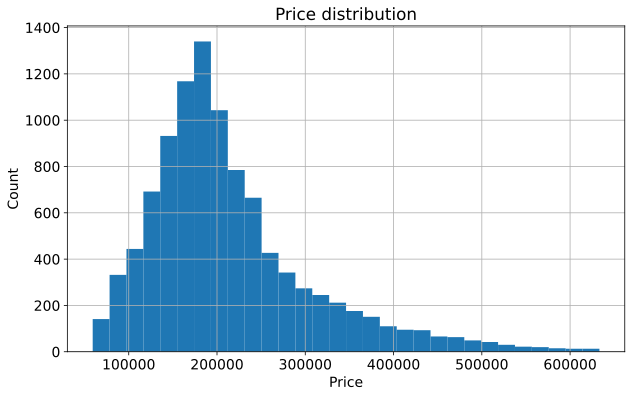

In [78]:
plt.figure(figsize = (10, 6))
plt.xlabel('Price')
plt.ylabel('Count')
plt.title('Price distribution')
train['Price'].hist(bins=30)
plt.show()

In [79]:
train.describe()

,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Price
count,10000.000000,10000.000000,7887.000000,10000.000000,10000.000000,10000.000000,1.000000e+04,10000.000000,10000.000000,10000.000000,10000.000000,5202.000000,10000.000000,10000.000000,10000.000000
mean,1.890500,56.315775,37.199645,6.273300,8.526700,12.609400,3.990166e+03,0.118858,24.687000,5352.157400,8.039200,1142.904460,1.319500,4.231300,214138.857399
std,0.839512,21.058732,86.241209,28.560917,5.241148,6.775974,2.005003e+05,0.119025,17.532614,4006.799803,23.831875,1021.517264,1.493601,4.806341,92872.293865
min,0.000000,1.136859,0.370619,0.000000,1.000000,0.000000,1.910000e+03,0.000000,0.000000,168.000000,0.000000,0.000000,0.000000,0.000000,59174.778028
25%,1.000000,41.774881,22.769832,1.000000,4.000000,9.000000,1.974000e+03,0.017647,6.000000,1564.000000,0.000000,350.000000,0.000000,1.000000,153872.633942
50%,2.000000,52.513310,32.781260,6.000000,7.000000,13.000000,1.977000e+03,0.075424,25.000000,5285.000000,2.000000,900.000000,1.000000,3.000000,192269.644879
75%,2.000000,65.900625,45.128803,9.000000,12.000000,17.000000,2.001000e+03,0.195781,36.000000,7227.000000,5.000000,1548.000000,2.000000,6.000000,249135.462171
max,19.000000,641.065193,7480.592129,2014.000000,42.000000,117.000000,2.005201e+07,0.521867,74.000000,19083.000000,141.000000,4849.000000,6.000000,23.000000,633233.466570


Есть пропуски данных в LifeSquare и Healthcare_1

### Посмотрим какие данные о числе комнат у нас есть.
Видим, что есть неадекватные значения 0, и очень большие значения (10, 19).
Квартиры, где 0 комнат, скорее всего являются студиями, поэтому выставлю им 1 комнату.
На сайте циан есть множество 6-комнатных квартир, больше комнат я не нашел, поэтому предположим, что 6 это максимальное число комнат.
Соответственно меняем значения выше 6 на медиану, то есть на 2.

In [80]:
train.Rooms.value_counts()

2.0     3880
1.0     3705
3.0     2235
4.0      150
5.0       18
0.0        8
10.0       2
19.0       1
6.0        1
Name: Rooms, dtype: int64

In [81]:
train['Rooms_outlier'] = 0

In [82]:
train.loc[(train.Rooms==0) | (train.Rooms>6), 'Rooms_outlier'] = 1
train.loc[train.Rooms==0, 'Rooms'] = 1
train.loc[train.Rooms>6, 'Rooms'] = train.Rooms.median()
train.Rooms.value_counts()

2.0    3883
1.0    3713
3.0    2235
4.0     150
5.0      18
6.0       1
Name: Rooms, dtype: int64

### Посмотрим на распределение площади квартир
Есть какое-то количество квартир с огромной площадью, на циане мало квартир с площадью больше 300м^2, в нашем датасете всего пара таких записей, поэтому возьму это значение за максимальное, а нижняя граница будет 20м^2, меньше этой площади практически не встречается.

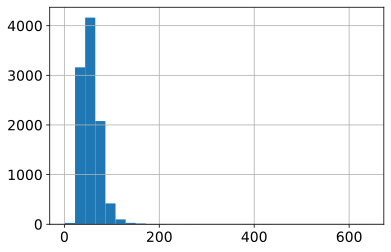

In [83]:
train.Square.hist(bins=30)
plt.show()

In [84]:
train['Square_outlier'] = 0

In [85]:
train.loc[(train.Square<20) | (train.Square>300), 'Square_outlier'] = 1

In [86]:
train.loc[(train.Square>300) | (train.Square<20), 'Square'] = train.Square.median()

In [87]:
train.Square.describe()

count    10000.000000
mean        56.256264
std         19.027939
min         20.213128
25%         41.811910
50%         52.513310
75%         65.889736
max        275.645284
Name: Square, dtype: float64

### Посмотрим на жилую площадь
В среднем, она составляет 60% от общей площади квартиры, сделаю так для квартир, где жилая площадь превышает общую, или меньше 40% общей площади(в основном туда входят очень маленькие значения), или где жилая больше 80% общей.

In [88]:
train['LifeSquare_outlier'] = 0
train.loc[(train.LifeSquare.isna()) |
          (train.LifeSquare>train.Square) |
          (train.LifeSquare<train.Square * 0.4) |
          (train.LifeSquare>train.Square * 0.8), 'LifeSquare_outlier'] = 1

In [89]:
train.loc[(train.LifeSquare.isna()) |
          (train.LifeSquare>train.Square) |
          (train.LifeSquare<train.Square * 0.4) |
          (train.LifeSquare>train.Square * 0.8), 'LifeSquare'] = 0.6 * train.Square
train.LifeSquare.describe()

count    10000.000000
mean        33.934538
std         12.094503
min         10.651455
25%         24.181158
50%         32.020108
75%         40.920233
max        165.387170
Name: LifeSquare, dtype: float64

### Площадь кухни
Где она больше жилой площади или больше квантили 97,5%, или меньше или равна 3м^2, заменю на медиану

In [90]:
train['KitchenSquare_outlier'] = 0
train.loc[(train.KitchenSquare>train.LifeSquare) |
          (train.KitchenSquare<=3) |
          (train.KitchenSquare>train.KitchenSquare.quantile(0.975)), 'KitchenSquare_outlier'] = 1

In [91]:
train.loc[(train.KitchenSquare>train.LifeSquare) |
          (train.KitchenSquare<=3) |
          (train.KitchenSquare>train.KitchenSquare.quantile(0.975)), 'KitchenSquare'] = train.KitchenSquare.median()
train.KitchenSquare.value_counts()

6.0     4410
8.0     1306
5.0     1169
10.0    1075
9.0      843
7.0      609
12.0     249
11.0     233
13.0      67
4.0       39
Name: KitchenSquare, dtype: int64

In [92]:
train.KitchenSquare.describe()

count    10000.000000
mean         7.193100
std          1.891711
min          4.000000
25%          6.000000
50%          6.000000
75%          8.000000
max         13.000000
Name: KitchenSquare, dtype: float64

### Этаж
Все выглядит нормально

In [93]:
train.Floor.describe()

count    10000.000000
mean         8.526700
std          5.241148
min          1.000000
25%          4.000000
50%          7.000000
75%         12.000000
max         42.000000
Name: Floor, dtype: float64

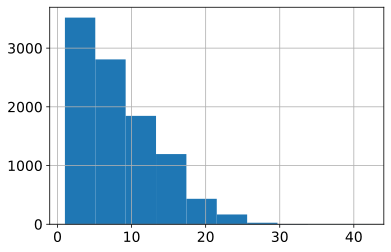

In [94]:
train.Floor.hist()
plt.show()

In [95]:
train.Floor.sort_values().unique()

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 31, 32, 33, 37, 42])

### Этаж здания
Самое высокое здание москвы, Башня Федерация, имеет 95 этажей, все выше этого значения меняю на медиану. 0 этажи меняю на 1. Где этаж квартиры выше этажности здания, меняю оба признака на соответствующие медианы.

In [96]:
train.HouseFloor.sort_values().unique()

array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
        13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
        26,  27,  28,  29,  30,  31,  32,  36,  37,  38,  39,  40,  44,
        45,  47,  48,  99, 117])

In [97]:
train['HouseFloor_outlier'] = 0
train.loc[(train.HouseFloor==0) | (train.Floor>train.HouseFloor) | (train.HouseFloor>95), 'HouseFloor_outlier'] = 1
train.loc[train.HouseFloor==0, 'HouseFloor'] = 1
train.loc[(train.HouseFloor>95) | (train.Floor>train.HouseFloor), 'HouseFloor'] = train.HouseFloor.median()
train.loc[train.Floor>train.HouseFloor, 'Floor'] = train.Floor.median()

In [98]:
train.HouseFloor.describe()

count    10000.000000
mean        13.817100
std          5.214285
min          1.000000
25%         10.000000
50%         13.000000
75%         17.000000
max         48.000000
Name: HouseFloor, dtype: float64

### Год постройки
Где год больше, чем текущий, меняю на текущий

In [99]:
train.HouseYear.value_counts()

1977        2652
2017         308
2016         305
2015         299
2014         210
            ... 
1947           1
1916           1
1910           1
1928           1
20052011       1
Name: HouseYear, Length: 97, dtype: int64

In [100]:
train.HouseYear.describe()

count    1.000000e+04
mean     3.990166e+03
std      2.005003e+05
min      1.910000e+03
25%      1.974000e+03
50%      1.977000e+03
75%      2.001000e+03
max      2.005201e+07
Name: HouseYear, dtype: float64

In [101]:
datetime.now().year

2021

In [102]:
train.loc[train.HouseYear>datetime.now().year, 'HouseYear'] = datetime.now().year
train.HouseYear.describe()

count    10000.000000
mean      1984.872600
std         18.416734
min       1910.000000
25%       1974.000000
50%       1977.000000
75%       2001.000000
max       2021.000000
Name: HouseYear, dtype: float64

In [103]:
train.median()

Id                         8394.500000
DistrictId                   36.000000
Rooms                         2.000000
Square                       52.513310
LifeSquare                   32.020108
KitchenSquare                 6.000000
Floor                         7.000000
HouseFloor                   13.000000
HouseYear                  1977.000000
Ecology_1                     0.075424
Social_1                     25.000000
Social_2                   5285.000000
Social_3                      2.000000
Healthcare_1                900.000000
Helthcare_2                   1.000000
Shops_1                       3.000000
Price                    192269.644879
Rooms_outlier                 0.000000
Square_outlier                0.000000
LifeSquare_outlier            0.000000
KitchenSquare_outlier         0.000000
HouseFloor_outlier            0.000000
dtype: float64

### Переведу буквенные бинарные категории в привычные численные и сделаю из айди района признак размера района

In [104]:
train.Ecology_2

0       B
1       B
2       B
3       B
4       B
       ..
9995    B
9996    B
9997    B
9998    B
9999    B
Name: Ecology_2, Length: 10000, dtype: object

In [105]:
binary_to_numbers = {'A': 0, 'B': 1}

train['Ecology_2'] = train['Ecology_2'].replace(binary_to_numbers)
train['Ecology_3'] = train['Ecology_3'].replace(binary_to_numbers)
train['Shops_2'] = train['Shops_2'].replace(binary_to_numbers)

In [106]:
district_size = train.DistrictId.value_counts().reset_index() \
                .rename(columns={'index':'DistrictId', 'DistrictId':'DistrictSize'})
district_size.head()

,DistrictId,DistrictSize
0,27,851
1,1,652
2,23,565
3,6,511
4,9,294


In [107]:
train = train.merge(district_size, on='DistrictId', how='left')

In [108]:
train

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,...,Helthcare_2,Shops_1,Shops_2,Price,Rooms_outlier,Square_outlier,LifeSquare_outlier,KitchenSquare_outlier,HouseFloor_outlier,DistrictSize
0,11809,27,3.0,115.027311,69.016386,10.0,4,10,2014,0.075424,...,0,0,1,305018.871089,0,0,1,0,0,851
1,3013,22,1.0,39.832524,23.169223,8.0,7,8,1966,0.118537,...,1,0,1,177734.553407,0,0,0,0,0,78
2,8215,1,3.0,78.342215,47.671972,10.0,2,17,1988,0.025609,...,3,1,1,282078.720850,0,0,0,0,0,652
3,2352,1,1.0,40.409907,24.245944,6.0,10,22,1977,0.007122,...,0,1,1,168106.007630,0,0,1,1,0,652
4,13866,94,2.0,64.285067,38.562517,9.0,16,16,1972,0.282798,...,0,6,1,343995.102962,0,0,0,0,0,89
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,1260,61,2.0,49.090728,33.272626,6.0,3,12,1981,0.300323,...,1,9,1,119367.455796,0,0,0,0,0,118
9996,16265,27,2.0,64.307684,37.038420,9.0,13,13,1977,0.072158,...,0,0,0,199715.148807,0,0,0,0,1,851
9997,2795,178,1.0,29.648057,16.555363,5.0,3,5,1958,0.460556,...,1,5,1,165953.912580,0,0,0,0,0,7
9998,14561,21,1.0,32.330292,22.326870,5.0,3,9,1969,0.194489,...,3,5,1,171842.411855,0,0,0,0,0,165


### Попробую предсказать отсутствующие данные из Ecology_1
Результат: 0.836, r2 train: 0.858

In [109]:
rf_model = RandomForestRegressor(n_estimators=100,
                                     criterion='mse',
                                     max_depth=20,
                                     min_samples_leaf=30,
                                     random_state=42)
feature_names = [i for i in train.columns if i[-4:] != 'lier']

rf_train = train.loc[~train.Healthcare_1.isna(), feature_names].drop(['Price', 'Healthcare_1'], axis=1)
rf_test = train.loc[~train.Healthcare_1.isna(), 'Healthcare_1']
X_train, X_test, y_train, y_test = train_test_split(rf_train, rf_test, test_size=0.3, random_state=42)

rf_model.fit(X_train, y_train)
y_pred = rf_model.predict(X_test)
y_train_pred = rf_model.predict(X_train)

print(f'r2 test: {r2(y_test, y_pred)}, r2 train: {r2(y_train, y_train_pred)}')

r2 test: 0.8367779431295856, r2 train: 0.8586080423912212


In [110]:
rf_train.head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Helthcare_2,Shops_1,Shops_2,DistrictSize
1,3013,22,1.0,39.832524,23.169223,8.0,7,8,1966,0.118537,1,1,30,6207,1,1,0,1,78
2,8215,1,3.0,78.342215,47.671972,10.0,2,17,1988,0.025609,1,1,33,5261,0,3,1,1,652
5,5804,99,3.0,62.528465,47.103833,6.0,9,9,1972,0.012339,1,1,35,5776,1,2,4,1,97
6,8864,44,1.0,33.938750,21.772930,9.0,1,12,1968,0.232205,1,1,24,4860,1,0,3,1,104
7,13072,59,2.0,50.391814,32.893256,8.0,8,17,1986,0.019509,1,1,37,7687,11,5,5,1,67


In [111]:
prepared_dataset = train.loc[train.Healthcare_1.isna(), feature_names].drop(['Price', 'Healthcare_1'], axis=1)
predicted_values = pd.Series(rf_model.predict(prepared_dataset), index=train.loc[train.Healthcare_1.isna(), 
                                                                                      'Healthcare_1'].index)

train.loc[train.Healthcare_1.isna(), 'Healthcare_1'] = predicted_values
train.Healthcare_1


0        611.521616
1       1183.000000
2        240.000000
3        542.442061
4       1887.244879
           ...     
9995    1036.314301
9996     625.622082
9997    1887.904914
9998     125.000000
9999    1589.120658
Name: Healthcare_1, Length: 10000, dtype: float64

### Делаю класс для предобработки численных данных

In [112]:
class DataPreprocessing:
    def __init__(self):
        self.medians = None
        self.kitchen_square_quantile = None
        self.rf_model = None
        self.binary_to_numbers = None
    def fit(self, X):
        self.medians = X.median()
        self.kitchen_square_quantile = X.KitchenSquare.quantile(0.975)
        self.binary_to_numbers = {'A': 0, 'B': 1}
    def transform(self, X):
        if 'Price' in X.columns:
            X = X.drop(columns='Price')
        
        X.Id = X.Id.astype(str)
        X.DistrictId = X.DistrictId.astype(str)
        
        # Binary to numbers
        X['Ecology_2'] = X['Ecology_2'].replace(binary_to_numbers)
        X['Ecology_3'] = X['Ecology_3'].replace(binary_to_numbers)
        X['Shops_2'] = X['Shops_2'].replace(binary_to_numbers)
        
        # DistrictSize
        district_size = X.DistrictId.value_counts().reset_index() \
                .rename(columns={'index':'DistrictId', 'DistrictId':'DistrictSize'})
        X = X.merge(district_size, on='DistrictId', how='left')
        
        # Rooms
        X['Rooms_outlier'] = 0
        X.loc[(X.Rooms==0) | (X.Rooms>6), 'Rooms_outlier'] = 1
        X.loc[X.Rooms==0, 'Rooms'] = 1
        X.loc[X.Rooms>6, 'Rooms'] = self.medians['Rooms']
        
        # Square 
        X['Square_outlier'] = 0
        X.loc[(X.Square<20) | (X.Square>300), 'Square_outlier'] = 1
        X.loc[(X.Square>300) | (X.Square<20), 'Square'] = self.medians['Square']
        
        # LifeSquare
        X['LifeSquare_outlier'] = 0
        condition = (X.LifeSquare.isna()) | \
                    (X.LifeSquare>X.Square) | \
                    (X.LifeSquare<X.Square * 0.4) | \
                    (X.LifeSquare>X.Square * 0.8)
        X.loc[condition, 'LifeSquare_outlier'] = 1
        X.loc[condition, 'LifeSquare'] = 0.6 * X.Square
        
        # KitchenSquare
        X['KitchenSquare_outlier'] = 0
        condition = (X.KitchenSquare>X.LifeSquare) | \
                    (X.KitchenSquare<=3) | \
                    (X.KitchenSquare>self.kitchen_square_quantile)
        X.loc[condition, 'KitchenSquare_outlier'] = 1
        X.loc[condition, 'KitchenSquare'] = self.medians['KitchenSquare']
        
        # Floor 
        # 0 этаж буду менять на 1, если такой придет
        X.loc[X.Floor==0, 'Floor'] = 1
        
        # HouseFloor
        X['HouseFloor_outlier'] = 0
        X.loc[(X.HouseFloor==0) | (X.Floor>X.HouseFloor) | (X.HouseFloor>95), 'HouseFloor_outlier'] = 1
        X.loc[X.HouseFloor==0, 'HouseFloor'] = 1
        X.loc[(X.HouseFloor>95) | (X.Floor>X.HouseFloor), 'HouseFloor'] = self.medians['HouseFloor']
        X.loc[X.Floor>X.HouseFloor, 'Floor'] = self.medians['Floor']

        # HouseYear
        X.loc[X.HouseYear>datetime.now().year, 'HouseYear'] = datetime.now().year
        
        
        
        # Healthcare_1 & binary to numbers
        
        rf_model = RandomForestRegressor(n_estimators=100,
                                     criterion='mse',
                                     max_depth=20,
                                     min_samples_leaf=30,
                                     random_state=42)
        feature_names = [i for i in X.columns if i[-4:] != 'lier']
        rf_train = X.loc[~X.Healthcare_1.isna(), feature_names].drop('Healthcare_1', axis=1)
        rf_test = X.loc[~X.Healthcare_1.isna(), 'Healthcare_1']
        X_train, X_test, y_train, y_test = train_test_split(rf_train, rf_test, test_size=0.3, random_state=42)
        rf_model.fit(X_train, y_train)
        prepared_dataset = X.loc[X.Healthcare_1.isna(), feature_names].drop('Healthcare_1', axis=1)
        predicted_values = pd.Series(rf_model.predict(prepared_dataset), index=X.loc[X.Healthcare_1.isna(), \
                                                                                              'Healthcare_1'].index)

        X.loc[X.Healthcare_1.isna(), 'Healthcare_1'] = predicted_values
        
        X.fillna(self.medians, inplace=True)
        
        return X


### Проверяю, что все работает нормально

In [113]:
X = pd.read_csv('train.csv')
X
preprocessor = DataPreprocessing()
preprocessor.fit(X)
X = preprocessor.transform(X)

X.head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,...,Healthcare_1,Helthcare_2,Shops_1,Shops_2,DistrictSize,Rooms_outlier,Square_outlier,LifeSquare_outlier,KitchenSquare_outlier,HouseFloor_outlier
0,11809,27,3.0,115.027311,69.016386,10.0,4.0,10.0,2014,0.075424,...,611.521616,0,0,1,851,0,0,1,0,0
1,3013,22,1.0,39.832524,23.169223,8.0,7.0,8.0,1966,0.118537,...,1183.000000,1,0,1,78,0,0,0,0,0
2,8215,1,3.0,78.342215,47.671972,10.0,2.0,17.0,1988,0.025609,...,240.000000,3,1,1,652,0,0,0,0,0
3,2352,1,1.0,40.409907,24.245944,6.0,10.0,22.0,1977,0.007122,...,542.442061,0,1,1,652,0,0,1,1,0
4,13866,94,2.0,64.285067,38.562517,9.0,16.0,16.0,1972,0.282798,...,1887.244879,0,6,1,89,0,0,0,0,0


In [114]:
def evaluate_preds(train_true_values, train_pred_values, test_true_values, test_pred_values):
    print("Train R2:\t" + str(round(r2(train_true_values, train_pred_values), 3)))
    print("Test R2:\t" + str(round(r2(test_true_values, test_pred_values), 3)))
    
    plt.figure(figsize=(10, 8))
    
    plt.subplot(121)
    sns.scatterplot(x=train_pred_values, y=train_true_values)
    plt.xlabel('Predicted values')
    plt.ylabel('True values')
    plt.title('Train sample prediction')
    
    plt.subplot(122)
    sns.scatterplot(x=test_pred_values, y=test_true_values)
    plt.xlabel('Predicted values')
    plt.ylabel('True values')
    plt.title('Test sample prediction')
    plt.subplots_adjust(wspace=0.35)
    plt.show()

### Попробую добавить еще признаки

In [115]:
med_price_by_district = train.groupby(['DistrictId', 'Rooms'], as_index=False).agg({'Price':'median'})\
                            .rename(columns={'Price':'MedPriceByDistrict'})
med_price_by_district.head()

,DistrictId,Rooms,MedPriceByDistrict
0,0,1.0,142799.434052
1,0,2.0,176210.812334
2,0,3.0,300610.359425
3,1,1.0,146735.671740
4,1,2.0,202666.310126


In [116]:
train = train.merge(med_price_by_district, how='left', on=['DistrictId', 'Rooms'])
train

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,...,Shops_1,Shops_2,Price,Rooms_outlier,Square_outlier,LifeSquare_outlier,KitchenSquare_outlier,HouseFloor_outlier,DistrictSize,MedPriceByDistrict
0,11809,27,3.0,115.027311,69.016386,10.0,4,10,2014,0.075424,...,0,1,305018.871089,0,0,1,0,0,851,213530.788443
1,3013,22,1.0,39.832524,23.169223,8.0,7,8,1966,0.118537,...,0,1,177734.553407,0,0,0,0,0,78,146032.829834
2,8215,1,3.0,78.342215,47.671972,10.0,2,17,1988,0.025609,...,1,1,282078.720850,0,0,0,0,0,652,244005.272380
3,2352,1,1.0,40.409907,24.245944,6.0,10,22,1977,0.007122,...,1,1,168106.007630,0,0,1,1,0,652,146735.671740
4,13866,94,2.0,64.285067,38.562517,9.0,16,16,1972,0.282798,...,6,1,343995.102962,0,0,0,0,0,89,201584.441255
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,1260,61,2.0,49.090728,33.272626,6.0,3,12,1981,0.300323,...,9,1,119367.455796,0,0,0,0,0,118,232514.855623
9996,16265,27,2.0,64.307684,37.038420,9.0,13,13,1977,0.072158,...,0,0,199715.148807,0,0,0,0,1,851,165683.084779
9997,2795,178,1.0,29.648057,16.555363,5.0,3,5,1958,0.460556,...,5,1,165953.912580,0,0,0,0,0,7,165953.912580
9998,14561,21,1.0,32.330292,22.326870,5.0,3,9,1969,0.194489,...,5,1,171842.411855,0,0,0,0,0,165,153921.400690


In [117]:
def floor_to_cat_pandas(X):
    bins = [0, 3, 5, 9, 15, X['Floor'].max()]
    X['Floor_cat'] = pd.cut(X['Floor'], bins=bins, labels=False)
    
    X['Floor_cat'].fillna(X.Floor_cat.median(), inplace=True)
    return X

def year_to_cat_pandas(X):
    bins = [0, 1940, 1945, 1980, 2000, 2010, X['HouseYear'].max()]
    X['Year_cat'] = pd.cut(X['HouseYear'], bins=bins, labels=False)
    
    X['Year_cat'].fillna(X.Year_cat.median(), inplace=True)
    return X

In [118]:
train = floor_to_cat_pandas(train)
train = year_to_cat_pandas(train)

In [119]:
# train

In [120]:
med_price_by_floor_year = train.groupby(['Floor_cat', 'Year_cat'], as_index=False).agg({'Price':'median'})\
.rename(columns={'Price':'MedPriceByFloorYear'})
med_price_by_floor_year.head()

,Floor_cat,Year_cat,MedPriceByFloorYear
0,0,0,380359.112959
1,0,1,467230.539057
2,0,2,177933.328473
3,0,3,204940.082609
4,0,4,238247.421498


In [121]:
train = train.merge(med_price_by_floor_year, how='left', on=['Floor_cat', 'Year_cat'])
train

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,...,Rooms_outlier,Square_outlier,LifeSquare_outlier,KitchenSquare_outlier,HouseFloor_outlier,DistrictSize,MedPriceByDistrict,Floor_cat,Year_cat,MedPriceByFloorYear
0,11809,27,3.0,115.027311,69.016386,10.0,4,10,2014,0.075424,...,0,0,1,0,0,851,213530.788443,1,5,161246.069193
1,3013,22,1.0,39.832524,23.169223,8.0,7,8,1966,0.118537,...,0,0,0,0,0,78,146032.829834,2,2,189340.643645
2,8215,1,3.0,78.342215,47.671972,10.0,2,17,1988,0.025609,...,0,0,0,0,0,652,244005.272380,0,3,204940.082609
3,2352,1,1.0,40.409907,24.245944,6.0,10,22,1977,0.007122,...,0,0,1,1,0,652,146735.671740,3,2,185088.409028
4,13866,94,2.0,64.285067,38.562517,9.0,16,16,1972,0.282798,...,0,0,0,0,0,89,201584.441255,4,2,171621.224416
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,1260,61,2.0,49.090728,33.272626,6.0,3,12,1981,0.300323,...,0,0,0,0,0,118,232514.855623,0,3,204940.082609
9996,16265,27,2.0,64.307684,37.038420,9.0,13,13,1977,0.072158,...,0,0,0,0,1,851,165683.084779,3,2,185088.409028
9997,2795,178,1.0,29.648057,16.555363,5.0,3,5,1958,0.460556,...,0,0,0,0,0,7,165953.912580,0,2,177933.328473
9998,14561,21,1.0,32.330292,22.326870,5.0,3,9,1969,0.194489,...,0,0,0,0,0,165,153921.400690,0,2,177933.328473


In [122]:
class FeaturesGenerator:
    def __init__(self):
        self.med_price_by_district = None
        self.house_year_max = None
        self.floor_max = None
        
    def fit(self, X, y=None):
        self.floor_max = df['Floor'].max()
        self.house_year_max = df['HouseYear'].max()
        X['Price'] = y.values
        self.med_price_by_district = X.groupby(['DistrictId', 'Rooms'], as_index=False).agg({'Price':'median'})\
                            .rename(columns={'Price':'MedPriceByDistrict'})
        self.med_price_by_district_median = self.med_price_by_district['MedPriceByDistrict'].median()
        
        X = self.floor_to_cat(X)
        X = self.year_to_cat(X)
        self.med_price_by_floor_year = X.groupby(['Floor_cat', 'Year_cat'], as_index=False).agg({'Price':'median'})\
                            .rename(columns={'Price':'MedPriceByFloorYear'})
        self.med_price_by_floor_year_median = self.med_price_by_floor_year['MedPriceByFloorYear'].median()
        
        
        
    def transform(self, X):
        X = self.floor_to_cat(X)
        X = self.year_to_cat(X)
        X = X.merge(self.med_price_by_district, how='left', on=['DistrictId', 'Rooms'])
        X.fillna(self.med_price_by_district_median, inplace=True)
        X = X.merge(med_price_by_floor_year, how='left', on=['Floor_cat', 'Year_cat'])
        X = self.floor_to_cat(X)
        X = self.year_to_cat(X)
        return X
    
    def floor_to_cat(self, X):
        bins = [0, 3, 5, 9, 15, self.floor_max]
        X['Floor_cat'] = pd.cut(X['Floor'], bins=bins, labels=False)

        X['Floor_cat'].fillna(X.Floor_cat.median(), inplace=True) 
        return X
    
    def year_to_cat(self, X):
        bins = [0, 1941, 1945, 1980, 2000, 2010, self.house_year_max]
        X['Year_cat'] = pd.cut(X['HouseYear'], bins=bins, labels=False)

        X['Year_cat'].fillna(X.Year_cat.median(), inplace=True)
        return X

In [123]:
df = pd.read_csv('train.csv')
X = df
y = df.Price

In [124]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, shuffle=True)

features = ['Rooms', 'Square', 'LifeSquare', 'KitchenSquare', 'Floor', 'HouseFloor', 'HouseYear',
            'Ecology_1', 'Ecology_2', 'Ecology_3', 'Social_1', 'Social_2', 'Social_3', 'Healthcare_1',
            'Helthcare_2', 'Shops_1', 'Shops_2', 'DistrictSize', 'Square_outlier', 
            'LifeSquare_outlier', 'KitchenSquare_outlier', 'HouseFloor_outlier', 'MedPriceByDistrict',
            'Floor_cat', 'Year_cat', 'MedPriceByFloorYear']

preprocessor = DataPreprocessing()
preprocessor.fit(X_train)

X_train = preprocessor.transform(X_train)

X_test = preprocessor.transform(X_test)

feature_gen = FeaturesGenerator()
feature_gen.fit(X_train, y_train)
X_train = feature_gen.transform(X_train)
X_test = feature_gen.transform(X_test)

X_train = X_train[features]
X_test = X_test[features]

In [125]:
X_train.describe()

,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,...,Shops_2,DistrictSize,Square_outlier,LifeSquare_outlier,KitchenSquare_outlier,HouseFloor_outlier,MedPriceByDistrict,Floor_cat,Year_cat,MedPriceByFloorYear
count,7000.000000,7000.000000,7000.000000,7000.000000,7000.000000,7000.000000,7000.000000,7000.000000,7000.000000,7000.000000,...,7000.000000,7000.000000,7000.000000,7000.000000,7000.000000,7000.000000,7000.000000,7000.000000,7000.000000,7000.000000
mean,1.887714,56.090729,33.812083,7.155286,7.884429,13.734857,1984.799143,0.118496,0.990571,0.973143,...,0.922714,168.685429,0.002143,0.358143,0.339286,0.179429,212177.205232,1.863143,2.808571,197613.026447
std,0.807677,18.842040,11.952446,1.843274,4.614555,5.199601,18.426670,0.118944,0.096649,0.161677,...,0.267063,185.562771,0.046245,0.479489,0.473501,0.383738,78536.114330,1.171218,1.166120,29035.553772
min,1.000000,20.606762,10.651455,4.000000,1.000000,1.000000,1910.000000,0.000000,0.000000,0.000000,...,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,74222.110465,0.000000,0.000000,159052.470665
25%,1.000000,41.847683,24.179246,6.000000,4.000000,10.000000,1974.000000,0.017647,1.000000,1.000000,...,1.000000,38.000000,0.000000,0.000000,0.000000,0.000000,162674.731269,1.000000,2.000000,184959.415038
50%,2.000000,52.529412,32.031673,6.000000,7.000000,13.000000,1977.000000,0.075424,1.000000,1.000000,...,1.000000,73.000000,0.000000,0.000000,0.000000,0.000000,194485.348389,2.000000,2.000000,187992.360093
75%,2.000000,65.594231,40.553634,8.000000,11.000000,17.000000,2001.000000,0.195781,1.000000,1.000000,...,1.000000,363.000000,0.000000,1.000000,1.000000,0.000000,244305.358328,3.000000,4.000000,209426.888767
max,5.000000,275.645284,165.387170,12.000000,37.000000,48.000000,2020.000000,0.521867,1.000000,1.000000,...,1.000000,581.000000,1.000000,1.000000,1.000000,1.000000,624156.003381,4.000000,5.000000,509182.957515


In [126]:
# regressor.fit(X_train, y_train)
# y_pred = regressor.predict(X_test)
# y_train_pred = regressor.predict(X_train)
# evaluate_preds(y_train, y_train_pred, y_test, y_pred)

### Результат:
Train R2:	0.773
Test R2:	0.644

In [127]:
# feature_importances = pd.DataFrame(zip(X_train.columns, regressor.feature_importances_), 
#                                    columns=['feature_name', 'importance'])

# feature_importances.sort_values(by='importance', ascending=False)

### Теперь попробую найти наилучшие параметры модели
Это n_estimators=400, max_depth=20, min_samples_leaf=10

In [128]:
# params = {'n_estimators':[50, 100, 200, 400], 
#           'max_depth':[10, 15, 20],
#           'min_samples_leaf':[10, 20, 30, 40]}

# gs = GridSearchCV(regressor, params, 
#                   scoring='r2', # метрика 
#                   cv=KFold(n_splits=5,   # k (кол-во разбиений/итераций) в кросс-валидации
#                            random_state=21, 
#                            shuffle=True),
#                   n_jobs=-1)
# gs.fit(X_train, y_train)

In [129]:
# rf_regressor = RandomForestRegressor(n_estimators=400,
#                                      criterion='mse',
#                                      max_depth=20,
#                                      min_samples_leaf=10,
#                                      random_state=42)

In [130]:
# rf_regressor.fit(X_train, y_train)
# y_pred = rf_regressor.predict(X_test)
# y_train_pred = rf_regressor.predict(X_train)
# evaluate_preds(y_train, y_train_pred, y_test, y_pred)

### Результат:
Train R2:	0.837
Test R2:	0.691

### Получилось лучше, сделаю теперь модель бустинга
Лучшие гиперпараметры:
{'learning_rate': 0.1, 'max_depth': 4, 'min_samples_split': 7, 'n_estimators': 200}

Лучший результат: 0.756

In [131]:
# params = {'n_estimators':[200, 300, 400], 
#           'max_depth':[3, 4, 5],
#           'min_samples_split':[4, 7],
#           'learning_rate':[0.1, 0.2, 0.3]}

# gs = GridSearchCV(GradientBoostingRegressor(random_state=42), params, 
#                   scoring='r2',
#                   cv=3)
# gs.fit(X_train, y_train)

In [132]:
# gs.best_params_

In [133]:
# gs.best_score_

In [134]:
boosting_regressor = GradientBoostingRegressor(n_estimators = 200, 
                                         max_depth = 4, 
                                         min_samples_split = 7, 
                                         learning_rate = 0.1,
                                              random_state=42)

Train R2:	0.87
Test R2:	0.724


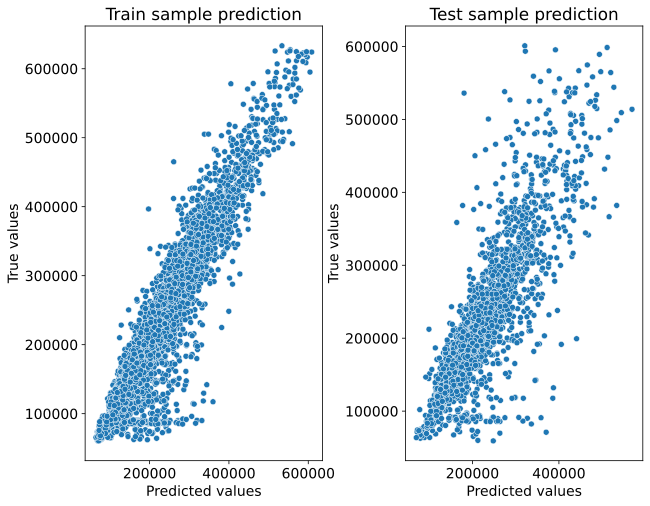

In [135]:
boosting_regressor.fit(X_train, y_train)
y_pred = boosting_regressor.predict(X_test)
y_train_pred = boosting_regressor.predict(X_train)
evaluate_preds(y_train, y_train_pred, y_test, y_pred)

### Результат:
Train R2:	0.87

Test R2:	0.722

In [136]:
cv_score = cross_val_score(boosting_regressor, X_train, y_train, scoring='r2', cv=KFold(n_splits=3, shuffle=True, random_state=21))
cv_score

array([0.72177025, 0.75956552, 0.74281169])

In [137]:
cv_score.mean()

0.7413824873995131

In [138]:
feature_importances = pd.DataFrame(zip(X_train.columns, boosting_regressor.feature_importances_), 
                                   columns=['feature_name', 'importance'])

feature_importances.sort_values(by='importance', ascending=False)

,feature_name,importance
22,MedPriceByDistrict,0.695151
1,Square,0.114852
17,DistrictSize,0.029360
2,LifeSquare,0.023266
25,MedPriceByFloorYear,0.017415
5,HouseFloor,0.017269
13,Healthcare_1,0.012972
6,HouseYear,0.012943
12,Social_3,0.012619
3,KitchenSquare,0.011771


### Считаю и загружаю предсказания на тестовой выборке

In [139]:
test = pd.read_csv('test.csv')
test = preprocessor.transform(test)
test = feature_gen.transform(test)

In [140]:
predictions = boosting_regressor.predict(test[features])
predictions

array([164192.06059864, 133951.4965746 , 159562.61820945, ...,
       144699.57927993, 177983.11903006, 256424.08082254])

In [141]:
submit = pd.read_csv('sample_submission.csv')
submit['Price'] = predictions

In [142]:
# submit.to_csv('boosting_submission3.csv', index=False)